In [1]:
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import math

# Get price history for assets

In [2]:
start_date = "2023-02-01"
end_date = "2024-02-01"

In [3]:
def get_asset_history(ticker_symbol, start_date, end_date, interval):
  ticker_data = yf.Ticker(ticker_symbol)
  ticker_df = ticker_data.history(start = start_date, end = end_date, interval = interval)
  return ticker_df

In [4]:
btc_history_5d = get_asset_history("BTC-USD", start_date, end_date, interval = "5d")

In [5]:
btc_history_1d = get_asset_history("BTC-USD", start_date, end_date, interval = "1d")

In [6]:
eth_history_1d = get_asset_history("ETH-USD", start_date, end_date, interval = "1d")

In [7]:
eth_history_5d = get_asset_history("ETH-USD", start_date, end_date, interval = "5d")

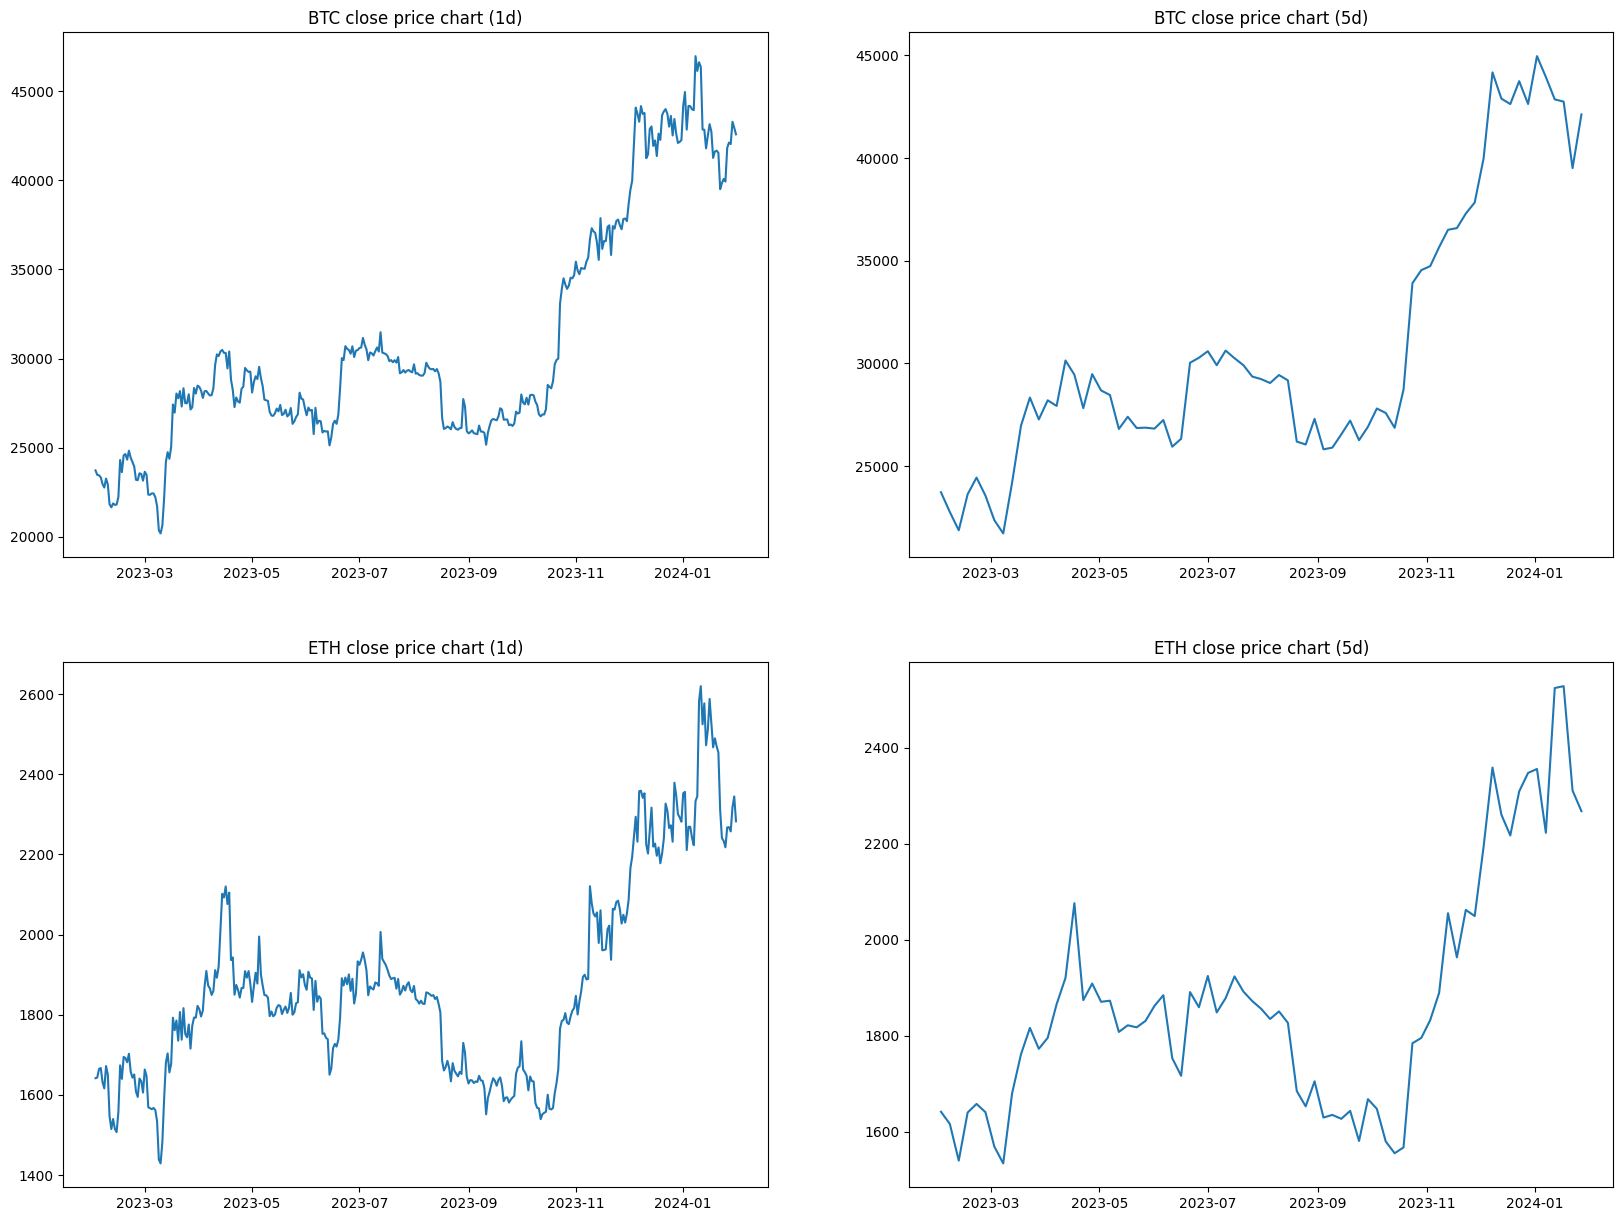

In [8]:
fig, axes = plt.subplots(2, 2, figsize = (20, 15))

axes[0, 0].plot(btc_history_1d.Close)
axes[0, 0].set_title("BTC close price chart (1d)")

axes[0, 1].plot(btc_history_5d.Close)
axes[0, 1].set_title("BTC close price chart (5d)")

axes[1, 0].plot(eth_history_1d.Close)
axes[1, 0].set_title("ETH close price chart (1d)")

axes[1, 1].plot(eth_history_5d.Close)
axes[1, 1].set_title("ETH close price chart (5d)")

plt.show()

# Indicators

In [9]:
def get_bollinger_bands(price_history, window, window_dev):
  bb = pd.DataFrame(index = price_history.index)
  bb["sma"] = price_history.Close.rolling(window = window).mean()
  bb["std"] = price_history.Close.rolling(window = window).std()

  # upper band
  bb["bollinger_hband"] = bb["sma"] + (bb["std"] * window_dev)

  # middle band
  bb["bollinger_mband"] = bb["sma"]

  # lower band
  bb["bollinger_lband"] = bb["sma"] - (bb["std"] * window_dev)

  return bb

In [10]:
def true_range(high, low, close):
  tr1 = high - low
  tr2 = abs(high - close.shift(1))
  tr3 = abs(low - close.shift(1))

  return pd.concat([tr1, tr2, tr3], axis = 1).max(axis = 1)

def get_keltner_channel(price_history, window, coefficient = 2):
  kc = pd.DataFrame(index = price_history.index)

  SMA = price_history.Close.rolling(window = window).mean()

  kc["tr"] = true_range(price_history.High, price_history.Low, price_history.Close)

  ATR_initial = kc["tr"].rolling(window = 14).mean()
  kc["atr"] = ATR_initial

  ATR = ( kc["tr"] + ((window - 1) * kc["atr"].shift(1)) ) / window

  upper_band = SMA + (ATR * coefficient)
  middle_band = SMA
  lower_band = SMA - (ATR * coefficient)

  kc["sma"] = SMA
  kc["kc_hband"] = upper_band
  kc["kc_mband"] = middle_band
  kc["kc_lband"] = lower_band
  return kc

In [11]:
def get_rsi(price_history, window):
  rsi = pd.DataFrame(index = price_history.index)

  rsi["change"] = price_history.Close.diff()
  rsi["gain"] = rsi["change"].apply(lambda x: x if x > 0 else 0)
  rsi["loss"] = rsi["change"].apply(lambda x: -x if x < 0 else 0)

  rsi["avg_gain"] = rsi["gain"].rolling(window = window).mean()
  rsi["avg_loss"] = rsi["loss"].rolling(window = window).mean()

  rsi["rs"] = rsi["avg_gain"] / rsi["avg_loss"]
  rsi["rsi"] = 100 - (100 / (1 + rsi["rs"]))

  return rsi["rsi"]

# Evaluation metrics

In [12]:
def calculate_sharpe(strategy, risk_free_rate = 0.04):
  mean_return = strategy["return"].mean() * 365
  volatility = strategy["return"].std() * math.sqrt(365)

  sharpe = (mean_return - risk_free_rate) / volatility

  return sharpe

In [13]:
def calculate_sortino(strategy, risk_free_rate = 0.04):
  mean_return = strategy["return"].mean() * 365
  negative_volatility = strategy["return"][strategy["return"] < 0].std() * math.sqrt(365)

  sortino = (mean_return - risk_free_rate) / negative_volatility

  return sortino

In [14]:
def calculate_max_drawdown(strategy):
  cumulative_returns = (strategy["return"] + 1).cumprod()
  cumulative_max = cumulative_returns.cummax()

  drawdowns = (cumulative_returns - cumulative_max) / cumulative_max

  max_drawdown = drawdowns.min() * 100

  return max_drawdown

In [15]:
def calculate_net_profit(strategy):
  net_profit = strategy["portfolio_value"].iat[-1] - strategy["portfolio_value"].iat[0]

  return net_profit


# Backtesting function for part 1


In [55]:
def backtest_1(price_history, params):
  window = params.get("window")
  window_dev = params.get("window_dev")
  rsi_window = params.get("rsi_window")
  rsi_overbought = params.get("rsi_overbought")
  rsi_oversold = params.get("rsi_oversold")
  initial_capital = params.get("initial_capital")

  long = False
  short = False
  # Bollinger Bands
  bb = get_bollinger_bands(price_history, window = window, window_dev = window_dev)

  # Keltner Channel
  kc = get_keltner_channel(price_history, window = window)

  # RSI
  rsi = get_rsi(price_history, rsi_window)

  strategy = pd.DataFrame(index = price_history.index,
                          columns = ["buy", "sell", "position"])
  strategy["buy"] = False
  strategy["sell"] = False

  for day in price_history.index:
    price = price_history.loc[day, "Close"]

      # price <= kc.kc_mband.loc[day] and \
    if (price <= bb.bollinger_lband.loc[day] and
        price <= kc.kc_lband.loc[day] and
        rsi.loc[day] <= rsi_oversold and
        not long):
      strategy.loc[day, "buy"] = True
      strategy.loc[day, "position"] = 1

      long = True
      short = False

      # price >= kc.kc_mband.loc[day] and \
    elif (price >= bb.bollinger_hband.loc[day] and
          price >= kc.kc_hband.loc[day] and
          rsi.loc[day] >= rsi_overbought and
          long):
      strategy.loc[day, "position"] = 0
      long = False

      # Short entry condition
    elif (price >= bb.bollinger_hband.loc[day] and
          price >= kc.kc_hband.loc[day] and
          rsi.loc[day] >= rsi_overbought and
          not short):
      strategy.loc[day, "sell"] = True
      strategy.loc[day, "position"] = -1
      short = True
      long = False

    # Short exit condition
    elif (price <= bb.bollinger_lband.loc[day] and
          price <= kc.kc_lband.loc[day] and
          rsi.loc[day] <= rsi_oversold and
          short):
      strategy.loc[day, "position"] = 0
      short = False


  strategy["position"] = strategy["position"].ffill().fillna(0)

  strategy["portfolio_value"] = initial_capital
  strategy["return"] = price_history.Close.pct_change() * strategy["position"].shift(1)
  strategy["portfolio_value"] = (strategy["return"] + 1).cumprod() * strategy["portfolio_value"].shift(1)
  strategy["return"] = strategy["portfolio_value"].pct_change()

  strategy = strategy.dropna()

  return strategy

# Backtesting function for part 2

In [17]:
def backtest_2(price_history, params):
  window = params.get("window")
  window_dev = params.get("window_dev")
  rsi_window = params.get("rsi_window")
  rsi_overbought = params.get("rsi_overbought")
  rsi_oversold = params.get("rsi_oversold")
  initial_capital = params.get("initial_capital")

  long = False
  short = True

  # Bollinger Bands
  bb = get_bollinger_bands(price_history, window = window, window_dev = window_dev)

  # RSI
  rsi = get_rsi(price_history, rsi_window)

  strategy = pd.DataFrame(index = price_history.index,
                          columns = ["buy", "sell", "position"])
  strategy["buy"] = False
  strategy["sell"] = False

  for day in range(len(price_history.index)):
    if day == 0:
      continue

    price_today = price_history.Close.iat[day]
    price_yesterday = price_history.Close.iat[day - 1]

      # price >= kc.keltner_channel_lband().loc[day] and \
    if (price_yesterday <= bb.bollinger_lband.iat[day] and
        not long):
      strategy["buy"].iat[day] = True
      strategy["position"].iat[day] = 1
      long = True
      short = False

      # price <= kc.keltner_channel_hband().loc[day] and \
    elif (price_yesterday >= bb.bollinger_hband.iat[day] and
          long):
      strategy["position"].iat[day] = 0
      long = False

    elif (price_yesterday >= bb.bollinger_hband.iat[day] and
          not short):
      strategy["sell"].iat[day] = True
      strategy["position"].iat[day] = -1
      short = True
      long = False

    elif (price_yesterday <= bb.bollinger_hband.iat[day] and
          short):
      strategy["position"].iat[day] = 0
      short = False

  strategy["position"] = strategy["position"].ffill().fillna(0)

  strategy["portfolio_value"] = initial_capital
  strategy["return"] = price_history.Open.pct_change() * strategy["position"].shift(1)
  strategy["portfolio_value"] = (strategy["return"] + 1).cumprod() * strategy["portfolio_value"].shift(1)
  strategy["return"] = strategy["portfolio_value"].pct_change()

  strategy = strategy.dropna()

  return strategy

In [18]:
def evaluate_strategy(strategy_results):
  net_profit = calculate_net_profit(strategy_results)
  sharpe = calculate_sharpe(strategy_results)
  sortino = calculate_sortino(strategy_results)
  max_drawdown = calculate_max_drawdown(strategy_results)

  print(f"Net Profit: {net_profit}")
  print(f"Annual Sharpe Ratio: {sharpe}")
  print(f"Annual Sortino Ratio: {sortino}")
  print(f"Maximum Drawdown: {max_drawdown}")
  print("====================================\n")

# Perform backtesting with initial parameters

# Backtest strategy 1

In [19]:
params_1 = {
    "window": 20,
    "window_dev": 2,
    "rsi_window": 14,
    "rsi_overbought": 70,
    "rsi_oversold": 30,
    "initial_capital": 1000,
}

In [56]:
strategy_1 = {
    "btc_1d": backtest_1(btc_history_1d, params_1),
    "btc_5d": backtest_1(btc_history_5d, params_1),
    "eth_1d": backtest_1(eth_history_1d, params_1),
    "eth_5d": backtest_1(eth_history_5d, params_1),
}

<ipython-input-55-4eef35e91291>:66: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  strategy["position"] = strategy["position"].ffill().fillna(0)
<ipython-input-55-4eef35e91291>:66: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  strategy["position"] = strategy["position"].ffill().fillna(0)
<ipython-input-55-4eef35e91291>:66: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_

# Backtest strategy 2

In [21]:
params_2 = {
    "window": 20,
    "window_dev": 2,
    "rsi_window": 14,
    "rsi_overbought": 70,
    "rsi_oversold": 30,
    "initial_capital": 2000,
}

In [22]:
strategy_2 = {
    "btc_1d": backtest_2(btc_history_1d, params_2),
}

<ipython-input-17-1e6c99b3e3dd>:56: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  strategy["position"] = strategy["position"].ffill().fillna(0)


# Results

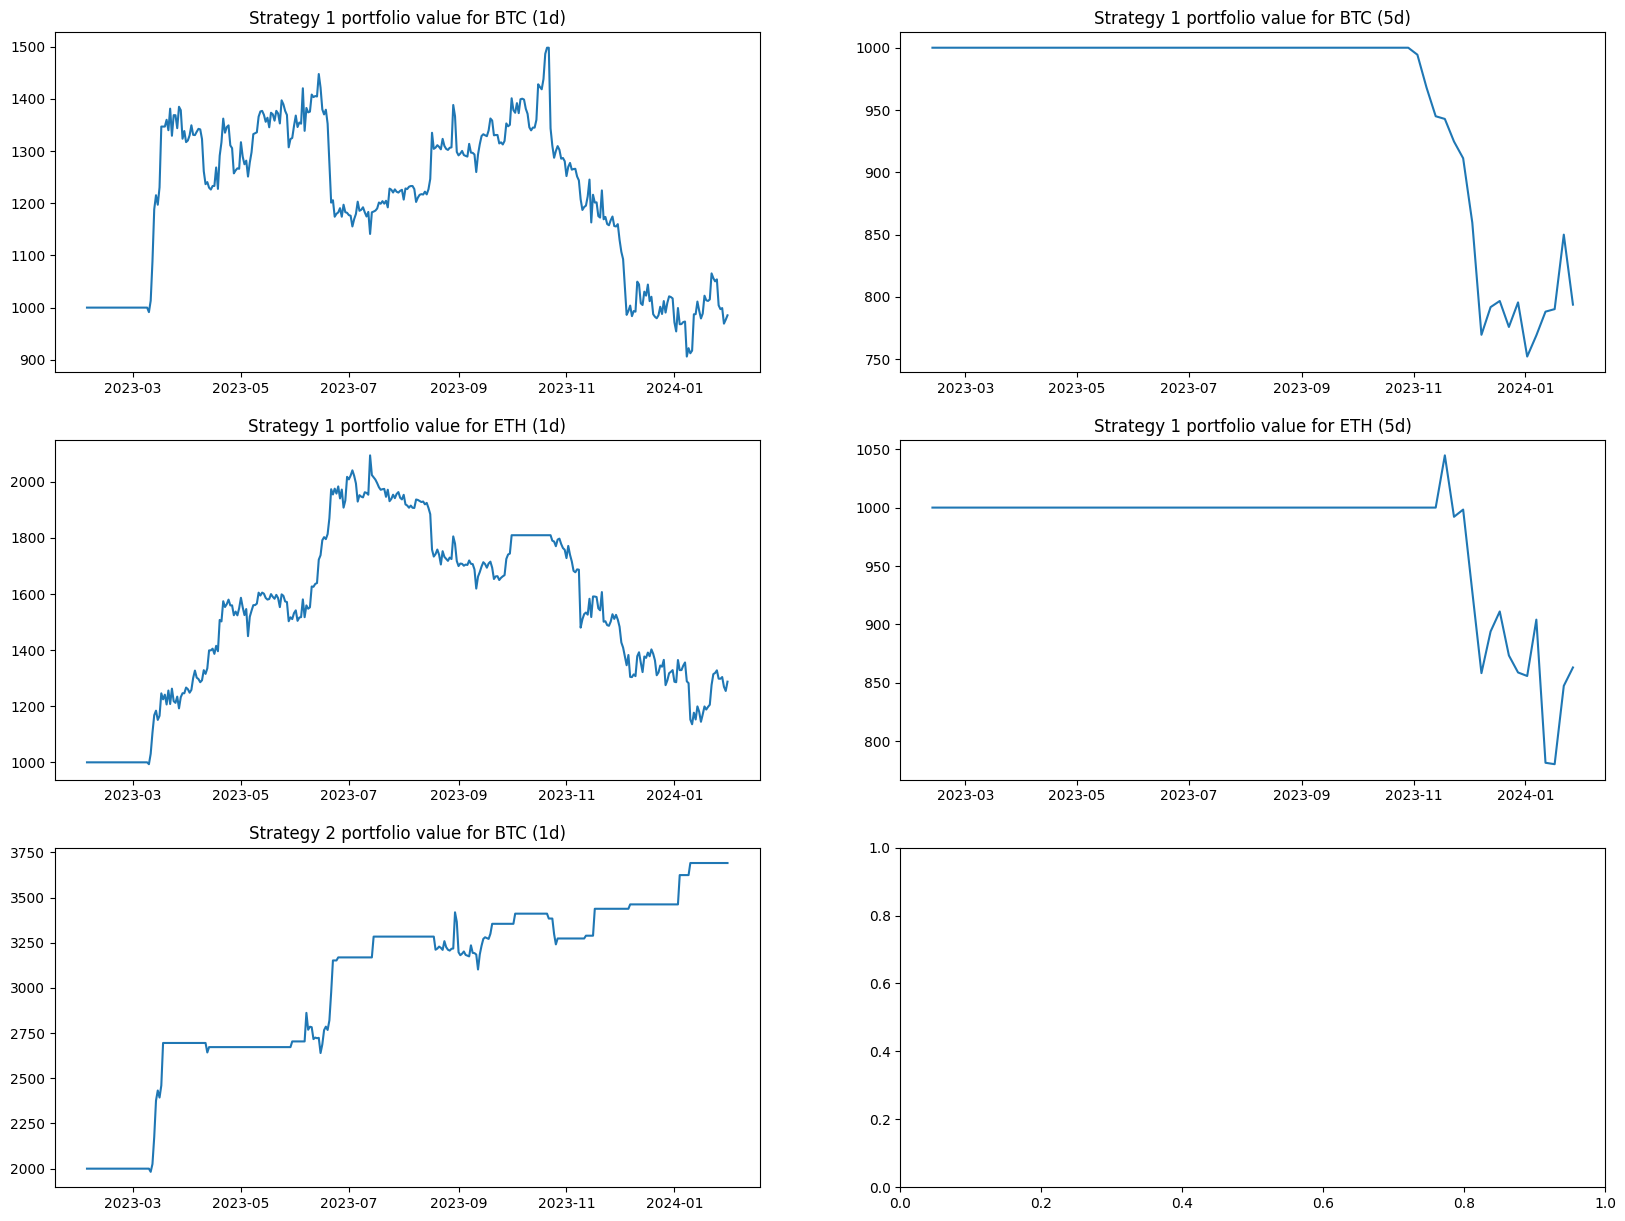

In [23]:
fig, axes = plt.subplots(3, 2, figsize = (20, 15))

axes[0, 0].plot(strategy_1.get("btc_1d")["portfolio_value"])
axes[0, 0].set_title("Strategy 1 portfolio value for BTC (1d)")

axes[0, 1].plot(strategy_1.get("btc_5d")["portfolio_value"])
axes[0, 1].set_title("Strategy 1 portfolio value for BTC (5d)")

axes[1, 0].plot(strategy_1.get("eth_1d")["portfolio_value"])
axes[1, 0].set_title("Strategy 1 portfolio value for ETH (1d)")

axes[1, 1].plot(strategy_1.get("eth_5d")["portfolio_value"])
axes[1, 1].set_title("Strategy 1 portfolio value for ETH (5d)")

axes[2, 0].plot(strategy_2.get("btc_1d")["portfolio_value"])
axes[2, 0].set_title("Strategy 2 portfolio value for BTC (1d)")
plt.show()

In [24]:
print("Strategy 1 results:\n")

print("BTC (1d time frame):\n")
evaluate_strategy(strategy_1.get("btc_1d"))
print("BTC (5d time frame):\n")
evaluate_strategy(strategy_1.get("btc_5d"))

print("ETH (1d time frame):\n")
evaluate_strategy(strategy_1.get("eth_1d"))
print("ETH (5d time frame):\n")
evaluate_strategy(strategy_1.get("eth_5d"))

print("Strategy 2 results for BTC (1d time frame):\n")
evaluate_strategy(strategy_2.get("btc_1d"))


Strategy 1 results:

BTC (1d time frame):

Net Profit: -14.755231727822661
Annual Sharpe Ratio: 0.07419657257549651
Annual Sortino Ratio: 0.09834393852787794
Maximum Drawdown: -39.49040786717835

BTC (5d time frame):

Net Profit: -206.30804841659722
Annual Sharpe Ratio: -2.8009081955670596
Annual Sortino Ratio: -1.9336595567151398
Maximum Drawdown: -24.79882936115504

ETH (1d time frame):

Net Profit: 287.4782579790351
Annual Sharpe Ratio: 0.7125099952816205
Annual Sortino Ratio: 0.8950068100183515
Maximum Drawdown: -45.76243964920527

ETH (5d time frame):

Net Profit: -136.99337746828553
Annual Sharpe Ratio: -1.3280665940408092
Annual Sortino Ratio: -0.7788509087089432
Maximum Drawdown: -25.327958929740586

Strategy 2 results for BTC (1d time frame):

Net Profit: 1690.9454708249814
Annual Sharpe Ratio: 2.527756283151811
Annual Sortino Ratio: 2.5806509720212594
Maximum Drawdown: -9.252751967049269



# Perform backtesting with adjusted parameters

# Backtest strategy 1


In [272]:
params_1_adj = {
    "window": 18,
    "window_dev": 1.4,
    "rsi_window": 12,
    "rsi_overbought": 80,
    "rsi_oversold": 25,
    "initial_capital": 1000,
}

In [273]:
strategy_1_adj = {
    "btc_1d": backtest_1(btc_history_1d, params_1_adj),
    "btc_5d": backtest_1(btc_history_5d, params_1_adj),
    "eth_1d": backtest_1(eth_history_1d, params_1_adj),
    "eth_5d": backtest_1(eth_history_5d, params_1_adj),
}

<ipython-input-55-4eef35e91291>:66: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  strategy["position"] = strategy["position"].ffill().fillna(0)
<ipython-input-55-4eef35e91291>:66: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  strategy["position"] = strategy["position"].ffill().fillna(0)
<ipython-input-55-4eef35e91291>:66: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_

# Backtest strategy 2


In [283]:
params_2_adj = {
    "window": 15,
    "window_dev": 1.8,
    "rsi_window": 14,
    "rsi_overbought": 65,
    "rsi_oversold": 35,
    "initial_capital": 2000,
}

In [284]:
strategy_2_adj = {
    "btc_1d": backtest_2(btc_history_1d, params_2_adj),
}

<ipython-input-17-1e6c99b3e3dd>:56: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  strategy["position"] = strategy["position"].ffill().fillna(0)


# Results


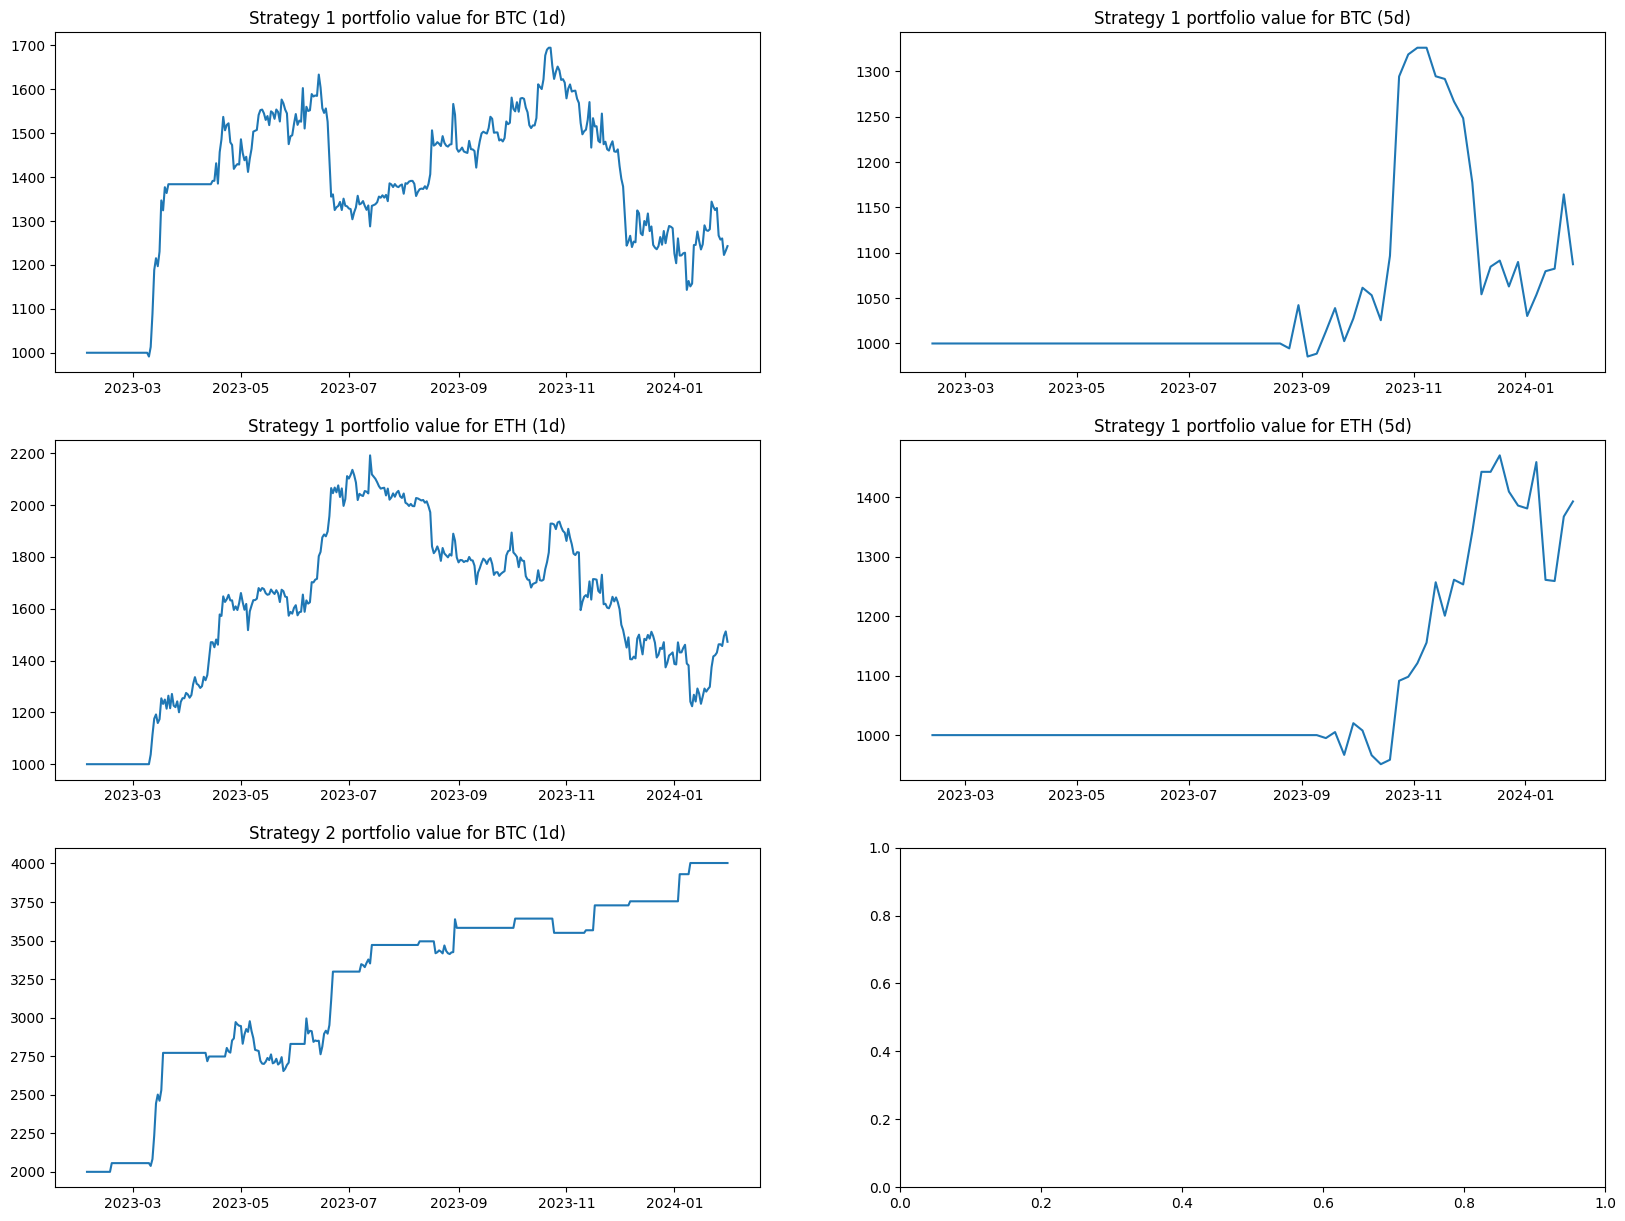

In [285]:
fig, axes = plt.subplots(3, 2, figsize = (20, 15))

axes[0, 0].plot(strategy_1_adj.get("btc_1d")["portfolio_value"])
axes[0, 0].set_title("Strategy 1 portfolio value for BTC (1d)")

axes[0, 1].plot(strategy_1_adj.get("btc_5d")["portfolio_value"])
axes[0, 1].set_title("Strategy 1 portfolio value for BTC (5d)")

axes[1, 0].plot(strategy_1_adj.get("eth_1d")["portfolio_value"])
axes[1, 0].set_title("Strategy 1 portfolio value for ETH (1d)")

axes[1, 1].plot(strategy_1_adj.get("eth_5d")["portfolio_value"])
axes[1, 1].set_title("Strategy 1 portfolio value for ETH (5d)")

axes[2, 0].plot(strategy_2_adj.get("btc_1d")["portfolio_value"])
axes[2, 0].set_title("Strategy 2 portfolio value for BTC (1d)")

plt.show()

In [286]:
print("Strategy 1 results:\n")

print("BTC (1d time frame):\n")
evaluate_strategy(strategy_1_adj.get("btc_1d"))
print("BTC (5d time frame):\n")
evaluate_strategy(strategy_1_adj.get("btc_5d"))

print("ETH (1d time frame):\n")
evaluate_strategy(strategy_1_adj.get("eth_1d"))
print("ETH (5d time frame):\n")
evaluate_strategy(strategy_1_adj.get("eth_5d"))

print("Strategy 2 results for BTC (1d time frame):\n")
evaluate_strategy(strategy_2_adj.get("btc_1d"))


Strategy 1 results:

BTC (1d time frame):

Net Profit: 242.72902899796463
Annual Sharpe Ratio: 0.6497181410617926
Annual Sortino Ratio: 0.8971486508599635
Maximum Drawdown: -32.53482186101816

BTC (5d time frame):

Net Profit: 87.4224049750685
Annual Sharpe Ratio: 0.9146581768662582
Annual Sortino Ratio: 1.074322118207427
Maximum Drawdown: -22.309904540319774

ETH (1d time frame):

Net Profit: 472.29497743954744
Annual Sharpe Ratio: 1.00706690396376
Annual Sortino Ratio: 1.3155073627120266
Maximum Drawdown: -44.172204784257964

ETH (5d time frame):

Net Profit: 392.7258638268954
Annual Sharpe Ratio: 2.89555497254375
Annual Sortino Ratio: 2.6412607002178845
Maximum Drawdown: -14.364909885182342

Strategy 2 results for BTC (1d time frame):

Net Profit: 2002.5501349650485
Annual Sharpe Ratio: 2.7230232966993304
Annual Sortino Ratio: 3.2813847707297485
Maximum Drawdown: -10.865004625792169

